# Worksheet 10

In this week's lab class you will gain experience with applying some Bayesian techniques in practice. There will be a quiz based on the worksheet, which you should complete first. The quiz is worth 5% of the assessment of the unit.

## Bayesian regression

We are going to fit a polynomial to a one-dimensional problem and explore its properties. First we import some useful packages. 

In [1]:
import numpy as np
import sklearn as sk
import numpy.linalg as la

import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge, LinearRegression

We next define a utility function that will create a non-linear function `f` of a vector `x` with noise added with standard deviation `noise_amount`.

In [2]:
def f(x, noise_amount):
    y = np.sqrt(x) * np.sin(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise

Now we define a function to plot results that we will use a lot in the following experiments. The four arguments it takes are a (fitted) Bayesian ridge regression model and a (fitted) ordinary regression model, the degree of the model and the number of training points.

In [3]:
def plot_results(clf, ols, degree, num_training_points):
    lw = 2
    plt.figure(figsize=(6, 5))
    plt.title("Weights of the model with n="+ str(num_training_points))
    plt.plot(clf.coef_, color='lightgreen', linewidth=lw,
             label="Bayesian Ridge estimate")
    #plt.plot(w, color='gold', linewidth=lw, label="Ground truth")
    plt.plot(ols.coef_, color='navy', linestyle='--', label="Linear regression estimate")
    plt.xlabel("Features")
    plt.ylabel("Values of the weights")
    plt.legend(loc="best", prop=dict(size=12))
    
    X_plot = np.linspace(0, 11, 30)
    y_plot = f(X_plot, noise_amount=0)
    y_mean, y_std = clf.predict(np.vander(X_plot, degree), return_std=True)
    y2_mean = ols.predict(np.vander(X_plot, degree))
    plt.figure(figsize=(6, 5))
    plt.errorbar(X_plot, y_mean, y_std, color='navy',
                 label="Polynomial Bayesian Ridge Regression", linewidth=lw)
    plt.plot(X_plot, y2_mean,  color='red', label='Linear Regression',
             linestyle='--', linewidth=lw)
    plt.plot(X_plot, y_plot, color='gold', linewidth=lw,
             label="Ground Truth")
    plt.ylabel("Output y")
    plt.xlabel("Feature X")
    plt.legend(loc="best")
    plt.show()

To see what the data generating function looks like, set the random seed, generate 100 equally spaced points (use np.linspace) in the range $(1, 10)$, and plot `f(x)` against `x` with `noise_amount=0.1`.

In [1]:
#TODO block 1


We are now going to fit polynomials using linear regression to various datasets generated with this function. To create the input functions, we will use the numpy function vander: API available [here](https://numpy.org/doc/stable/reference/generated/numpy.vander.html) 

This function generates polynomial basis function values from a row vector. Use it to create a matrix up to third order for the vector $(1, 2, 3)$ and print the result.

In [2]:
#TODO block 2


At this point it is worth reading the sklearn documentation about Bayesian ridge regression which can be found [here](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression) (and the earlier part of Section 1.1.10). The parameter $\alpha$ is the precision (inverse variance) of the noise model (what we called $\beta$ in the lectures) while the parameter $\lambda$ is the precision of the weight prior (what we called $\alpha$ in the lectures). 

You should create the Bayesian ridge regression model with `compute_score=True` and fit it with degree equal to 10 to 100 equally spaced points in the range $(1, 10)$ (remember to set the seed to 1729 first) and noise standard deviation $0.1$. The input values should be generated using the vander function at the data points.

Do the same for a linear regression model and then call `plot_results`

In [3]:
#TODO block 3


Here are the first ![First graph](graph1.png) and second graphs ![Second graph](graph2.png)

If you have got that right, you are ready to carry out your first experiment. Let the number of points in the training set
vary in the selection $(8, 9, 10, 11, 12, 20, 40, 100)$ and repeat the fitting process above for each of these training
sets (reset the random seed on each iteration). Print out the final fitted value of `alpha` in the Bayesian ridge 
regression model at each iteration of this process. Compare it to what the true value is.

Look at all the graphs you generate and the values of weights and parameters. Write down your analysis of these results - you will need this for the quiz.

In [4]:
#TODO block 4



Write your answer here.

Now repeat the experiment above but with the `noise_amount` parameter set to 1.0 instead of 0.1. Again, note the values of
`alpha` and analyse the graphs.

In [5]:
#TODO block 5



Write your answer here.

## Evidence procedure for PCA
In this section we are going to do some experiments to compare the evidence procedure for PCA with cross-validation and also with a related model called Factor Analysis. First we import some relevant packages.

In [9]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
import time

Next we create some synthetic data. There are 1000 data points in 50-dimensional space and the data has rank 10. We achieve this by using singular value decomposition to create a lower rank basis. The homogeneous noise data `X_hom` has the same variance in each dimension while the heterogeneous noise data `X_het` has randomly varying variance in each dimension.

In [10]:
# Create the data
n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = la.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_hom = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_het = X + rng.randn(n_samples, n_features) * sigmas

The following function `compute_scores` takes a dimensionality reduction model and uses cross-validation to 
compute the log likelihood of it when
fitted to a dataset a range of numbers of components using the `sklearn` function `cross_val_score`: information
    [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). It does this
    by fitting the model and applying 5-fold cross-validation (the default).

In [11]:
n_components = np.arange(0, n_features, 1)  # options for n_components

def compute_scores(X, model):
    
    scores = []
    for n in n_components:
        model.n_components = n
        scores.append(np.mean(cross_val_score(model, X)))
    return scores

The next task is to compare PCA with the evidence procedure with PCA using cross-validation and factor analysis using cross-validation. Factor analysis is very similar to probabilistic PCA but the noise model is diagonal instead of spherical (also
known as *isotropic*): see [API](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html).

You should create a PCA model with the full SVD solver and a Factor Analysis model. Fit and score them (using `compute_scores`) for all numbers of components from 1 to 50 and store the result in a variable `pca_scores` and `fa_scores` respectively. Measure how long `compute_scores` takes for each model and print the results.

Then fit a single PCA using mle (which ensures that the evidence procedure is used). Time this as well and print the result.

Do this for the homogeneous data `X_hom`. The code may take 1-2 minutes to run. Review the graph and timings and analyse what they tell you.

In [ ]:

X = X_hom
title = 'Homoscedastic Noise'

#TODO block 6a 
#Do cross-validation here


n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

#TODO block 6b
# Do evidence procedure here

n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa,
            linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
            label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')


plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='best')
plt.title(title);

Write your answer here.

Now carry out the same experiment for the heterogeneous dataset `X_het` and analyse the results.

In [ ]:


X = X_het
title = 'Heteroscedastic Noise'

#TODO block 7a



n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

#TODO block 7b

n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa,
            linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
            label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')


plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='best')
plt.title(title);

Write here.

## Variational Gaussian mixture models
In this section we will see how variational Bayesian methods help us to fit Gaussian mixture models. First we load and normalise the Old Faithful dataset. An overview of the sklearn mixture models can be found [here](https://scikit-learn.org/stable/modules/mixture.html)

In [14]:
import pandas as pd
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib as mpl

df = pd.read_excel('OldFaithfulData.xlsx')

Next we create a data matrix and then standardise the data (normalise each variable to zero mean and unit variance). This is often a good pre-processing step to apply if you are fitting non-linear models.

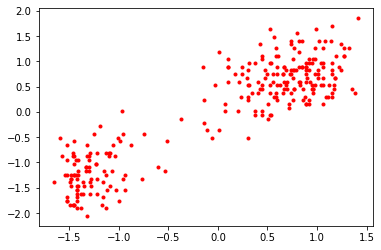

In [15]:
data = df.to_numpy()

scaler = StandardScaler().fit(data)
X = scaler.transform(data)


plt.plot(X[:, 0], X[:, 1], 'r.')
plt.show()

In the next block of code, we create a function that we will use to plot the results of fitting various mixture models. In this function, the first parameter is the data, the second is the predicted label at the data, the third and fourth are the means and covariances extracted from the mixture model. The index should be incremented by one each time it is called since it gives the index of the sub-plot on that iteration. 

In [21]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'green'])

def plot_gmm_results(X, Y_, means, covariances, index, title):
    plt.figure(figsize=(10,8));
    
    splot, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = la.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / la.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    plt.xlim(-2., 2.)
    plt.ylim(-2.5, 2.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title);

Now create a Gaussian mixture model (`mixture.GaussianMixture`) with 6 components, full covariance matrices, a random state of 1729 and fit it to the dataset `X`. 

In [8]:
#TODO block 8


Now fit a Bayesian GMM (`mixture.BayesianGaussianMixture`) with the same parameters, but also specifying the `weight_concentration_prior_type` to be `'dirichlet_distribution'`. Plot the results (with `index=1`). This is the 
[API](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture)

In [9]:
#TODO block 9


The default value of the mixing coefficient hyperprior (known as the *weight concentration prior* in this implementation) is 
`1/n_components`. Now carry out the same experiment setting it to $10^{-3}$, $1$, and $1000$. Then review the five graphs (two above and three below) and write down your analysis of them.

In [10]:
#TODO block 10



Write your answer here.